In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import matplotlib.pyplot as plt 
from string import punctuation

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [4]:
sort_total_years = pd.read_csv('sort_total_years.csv')
# 2020년대 곡
y20 = sort_total_years[sort_total_years['year'].str.contains('2020y')]
y21 = sort_total_years[sort_total_years['year'].str.contains('2021y')]
# latest = y20.append(y21)

In [5]:
y20_100 = y20[:100]
y21_100 = y21[:100]

In [6]:
latest_100 = y20_100.append(y21_100)

## 불용어

In [7]:
 # 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하','부터','처럼','까지',
          'know','no','of','let','my','수','너','내','나','그','난','봐',
          '돼','건','모든','에서','에게','싶어','잖아',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기',
          '다시','하게','니까',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면',
          '같아','있어',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린','하지',
          '해도','하고','없어','않아',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜',
          '거야','이제','그냥','했던','하는']
# 우리 , 그대 , 사랑 , 지금

In [8]:
len(stop_w)

120

## 신조어 단어 사전 추가
### ckonlpy 

In [9]:
from ckonlpy.tag import Twitter
twitter = Twitter()

## 신조어 정의
참고 링크
* https://blog.naver.com/dic_master/221436020989
* https://open-pro.dict.naver.com/_ivo/dictmain?dictID=enegdwdxdyebegdxdwdsqyofgwrzrzuc&listType=1&page=9
* https://open-pro.dict.naver.com/_ivo/dictmain?dictID=enegdwdxdyebegdxdwdsqyofbjqyiebp&page=5

In [10]:
add_words = ['먹방','대박','귀요미','네티즌','갑질','짱','사재기','인플루언서',
             '탕진잼', '인싸', '자만추', '카카오톡', '현타',
'플렉스','번아웃','티키타카','스포','스포일러','꼰대','밈','내로남불',
'인싸','아싸','이모티콘','최애','시강','시선강탈','절교','근자감','인만추',
'썸네일','탕진잼','사이다','자존감','정주행','코스프레','셀럽','하드캐리',
'해시태그','스타벅스','인스타','인스타그램','카카오톡','네이버','넷플릭스',
'유레카','치맥','랜선','듣보잡','남사친','여사친','레알','셀카','셀피','셀카봉',
'떡상','프사','카톡','읽씹','존버','지못미','불멍','취존','어그로','손절',
'버킷리스트','어벤져스','콜라보','케미','라떼','수능','화양연화','콘텐츠','현타',
'할로윈','크리스마스','마카롱','크로플','반박불가','솔까','알못','꽃길','힐링',
'고인물','언팔','팔로우','맞팔','포스팅','갤러리','소울메이트','타임라인',
'그루브','발라드','혼밥','프로포즈','데칼코마니','비트','아티스트','래퍼','힙합',
'디엠','트위터','선팔','떡밥','스트리밍','브이','레인보우','와이파이',
'아이돌','히트','댓글','컬러링','혼술','센치','방탄소년단','아이유','아이오아이',
'아메리카노','티켓','베프','스밍','버건디','아이템','지옥철','트렌드','트렌디',
'데님','카라','후드','비주얼','레알','스마트폰','플레이리스트','유튜브','어플',
'핫스팟','업로드','채팅','싸이월드','페이스북','페북','보이스','배경화면',
'서버','키보드','마우스','블루투스','솔로','캘리그라피',
'이모티콘','아이폰','꽁냥','컨텐츠','클라우드','메신저','메시지',
'존버','즐겨찾기','바탕화면','치킨','마시멜로','초콜렛','케이크','케잌','스무디',
'팝콘','시리얼','앱','지못미','츄러스','빼빼로','퐁듀','에스프레소',
'프라푸치노','카푸치노','달고나','파스타','까르보나라','팥빙수','악플',
'데스티니','썸남','썸녀','밀당','젤리','마들렌','토스트','밀크티','푸딩',
'이벤트','머핀','에이드','라임','버블티','쉐이크','캘리','프러포즈','퍼즐',
'옥탑방','팔레트','망고','심쿵','하트','휘게','예스','소맥',
'모히또','샴페인','아이언맨','집순','폴라로이드','롤링페이퍼','홍대','컬쳐','체리','블루베리',
'출첵','프로젝트','뉴욕','할리우드','헐리웃','등골 브레이커','어장관리','멘붕','쩔어','노잼',
'하드캐리','페이스','아몬드','싱글','메이크업','크레딧','아트','러블리','애니','시티']

In [11]:
len(add_words)

236

In [12]:
# 리스트에 담긴 단어만큼 사전에 추가
for i in range(len(add_words)):
    twitter.add_dictionary(add_words[i], 'Noun')

## 가사 토큰화

In [13]:
word_list = latest_100['Lyric'].apply(lambda x: [word for word in twitter.nouns(x) if word not in stop_w])

In [14]:
word_list

3308    [마음, 상처, 음악, 연고, 발라, 밤, 밤, 바바바, 밤, 발라, 밤, 밤, 바...
3309    [밤, 그날, 반딧불, 당신, 창, 가까이, 음, 사랑, 우리, 첫, 입맞춤, 언제...
3310    [곁, 이대, 이별, 조금, 멀리, 뿐, 모두, 지나, 간, 기억, 속, 눈물, 만...
3311    [웃, 생각, 눈물, 이나, 시간, 준, 사람, 테, 항상, 고단, 하루, 유일, ...
3312    [뭐, 행복, 머리, 저, 하늘, 높이, 그때, 니, 두, 날개, 눈, 전부, 조금...
                              ...                        
3695    [자꾸, 연구, 아인슈타인, 고, 각, 재, 고, 밀고, 스타일, 고, 아보, 거,...
3697    [방금, 어깰, 토닥, 바, 라보, 아무, 끌, 어안, 우리, 오늘, 이별, 기억,...
3698    [단위, 숨, 탁, 신경, 거절, 어디, 눈, 거울, 속, 마주, 멀리, 멀리, 오...
3700    [뒷모습, 분홍, 빛, 이나, 새, 조명, 번쩍, 번쩍, 세상, 머리, 비운, 감정...
3702    [어진, 하루, 길, 어진, 그림자, 저, 멀리, 어둠, 속, 헤메, 곳, 아직, ...
Name: Lyric, Length: 200, dtype: object

## 단어 벡터화 및 토픽 모델링

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 설정해준 카테고리의 데이터들만 추출
# CountVectorizer로 텍스트 데이터들 단어 빈도수에 기반해 벡터화시키기(fit_transform까지!)
count_vect = CountVectorizer(max_df=0.95, max_features=1000,
                            min_df=2, stop_words=stop_w,
                            ngram_range=(1,5)) # (min_n, max_n) 튜플 : n-그램 범위
ftr_vect = count_vect.fit_transform(word_list.astype(str))


# LDA클래스를 이용해서 피처 벡터화시킨 것을 토픽모델링 시키기
# n_components(토픽개수) 3로 설정
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(ftr_vect)
# components_속성은 3개의 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)

(3, 1000)
[[ 5.16047483  0.85716253  8.22871042 ...  5.33323757  3.33324038
   2.33797516]
 [ 0.33626074 17.54112241  4.80511733 ...  0.33338005  0.33337793
   1.32847097]
 [ 1.50326442  1.60171506 22.96617225 ...  0.33338238  0.33338169
   0.33355386]]


In [16]:
# transform까지 수행하면, 문서별(row)로 토픽들(column)의 분포를 알려줌
doc_topics = lda.transform(ftr_vect)
print(doc_topics.shape)
print(doc_topics[:2]) # 두 곡에 대한 확률 정보 

(200, 3)
[[0.48902955 0.49273251 0.01823793]
 [0.00933006 0.98134392 0.00932602]]


`(200, 3)` ==> 문서 200개 , 3개의 토픽<br>
`[[0.48902955 0.49273251 0.01823793]` 첫 번째 문서(노래) 에 대한 각 토픽에 해당될 확률<br>
 `[0.00933006 0.98134392 0.00932602]]`두 번째 문서(노래) 에 대한 각 토픽에 해당될 확률<br>

In [17]:
def display_topic_words(lda_model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print('\nTopic #', topic_idx+1)
        
        # Topic별로 1000개의 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌

        topic_word_idx = topic.argsort()[::-1] # argsort()는 디폴트가 오름차순, [::-1]로 내림차순 변경
        top_idx = topic_word_idx[:num_top_words]
        
        # CountVectorizer함수 할당시킨 객체에 get_feature_names()로 벡터화시킨 feature(단어들)볼 수 있음
        # 이 벡터화시킨 단어들(features)은 숫자-알파벳순으로 정렬되며, 단어들 순서는 fit_transform시키고 난 이후에도 동일!
        # '문자열'.join 함수로 특정 문자열 사이에 끼고 문자열 합쳐줄 수 있음.
        feature_concat = '+'.join([str(feature_names[i])+'*'+str(round(topic[i], 1)) for i in top_idx])
        print(feature_concat)        
        
feature_names = count_vect.get_feature_names()
display_topic_words(lda, feature_names, 15)


Topic # 1
생각*54.1+세상*48.2+시간*48.0+사랑*44.3+지금*40.4+어디*39.9+우리*37.9+소리*37.4+모두*30.9+순간*29.8+친구*28.3+내일*27.2+하루*26.7+아무*26.2+머리*25.8

Topic # 2
그대*152.2+우리*125.4+사랑*118.6+다운*63.1+기억*58.0+아름*55.3+세상*52.6+시간*50.0+오늘*48.0+조금*42.3+아름 다운*40.3+마음*35.8+아무*35.1+위로*31.8+멀리*31.7

Topic # 3
사랑*155.1+마음*81.3+사람*65.5+노래*57.2+아무*45.7+우리*41.6+지금*39.0+아마*37.3+생각*33.4+사랑 사랑*30.0+아주*29.8+이대*28.5+영원*27.3+시간*27.0+가끔*23.0


## 노래에 대한 각 토픽 확률

In [18]:
# 주어진 내장 텍스트데이터의 문서이름에는 카테고리가 labeling되어있음. 
# 따라서, 카테고리가 무엇인지 아는 상태이니까 어떤 문서들이 어떤 토픽들이 높은지 확인해보자.
# 그리고 그 토픽들이 각각 무엇을 내용으로 하는지 추측해보자.
# 주어진 데이터셋의 filename속성을 이용해서 카테고리값들 가져오기
def get_filename_list(latest_100):
    filename_lst = []
    for file in latest_100.song_name:
        filename_temp = file.split('/')[-2:]
        filename = '.'.join(filename_temp)
        filename_lst.append(filename)
    return filename_lst
 
filename_lst = get_filename_list(latest_100)
# Dataframe형태로 만들어보기
topic_names = ['Topic #'+ str(i) for i in range(1,4)]
topic_df = pd.DataFrame(data=doc_topics, columns=topic_names,
                       index=filename_lst)
# print(topic_df.head(20))

In [19]:
topic_df

,Topic #1,Topic #2,Topic #3
Monster (Korean ver.),0.489030,0.492733,0.018238
밤편지,0.009330,0.981344,0.009326
I Believe (엽기적인 그녀 O.S.T),0.006816,0.986314,0.006870
"모든 날, 모든 순간 (Every day, Every Moment)",0.982487,0.008958,0.008555
작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey),0.983751,0.008104,0.008145
...,...,...,...
SCIENTIST,0.985095,0.007320,0.007585
마지막 날에 (Moving On),0.006249,0.879620,0.114131
MAVERICK,0.661576,0.329016,0.009409
LALISA,0.644196,0.020023,0.335781


## Topic # 1
**생각*54.1+세상*48.2+시간*48.0+사랑*44.3+지금*40.4**+어디*39.9+우리*37.9+소리*37.4+모두*30.9+순간*29.8+친구*28.3+내일*27.2+하루*26.7+아무*26.2+머리*25.8

## Topic # 2
**그대*152.2+우리*125.4+사랑*118.6+다운*63.1+기억*58.0**+아름*55.3+세상*52.6+시간*50.0+오늘*48.0+조금*42.3+아름 다운*40.3+마음*35.8+아무*35.1+위로*31.8+멀리*31.7


## Topic # 3
**사랑*155.1+마음*81.3+사람*65.5+노래*57.2+아무*45.7**+우리*41.6+지금*39.0+아마*37.3+생각*33.4+사랑 사랑*30.0+아주*29.8+이대*28.5+영원*27.3+시간*27.0+가끔*23.0

---

## 가장 높은 확률의 토픽만 추출

In [20]:
# 문서별로, 가장 확률이 높은 topic으로 할당해줌

doc_topic = lda.transform(ftr_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])
    
doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])

doc_topic_df.head()

,Doc_Num,Topic,Percentage
0,0,1,0.492733
1,1,1,0.981344
2,2,1,0.986314
3,3,0,0.982487
4,4,0,0.983751


In [21]:
latest_100.reset_index(drop=True,inplace=True) # 인덱스(iloc)가 일치해야 join 가능

## 곡 정보 & 토픽 모델링 결과

In [22]:
doc_topic_df = doc_topic_df.join(latest_100,lsuffix='index')
doc_topic_df.drop('Doc_Num', axis=1,inplace=True)
doc_topic_df.head()

,Topic,Percentage,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,tags,year
0,1,0.492733,1764294,Monster (Korean ver.),드렁큰 타이거(Drunken Tiger),Feel gHood Muzik - The 8th Wonder,67572,아픈 마음의 상처에 음악의 연고를 발라버려 밤 밤 바바바 밤발라버려 밤 밤...,https://image.bugsm.co.kr/album/images/200/189...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
1,1,0.981344,30598121,밤편지,아이유(IU),밤편지,38694,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말 이에요 ...,https://image.bugsm.co.kr/album/images/200/200...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y
2,1,0.986314,517714,I Believe (엽기적인 그녀 O.S.T),신승훈,The Shin Seung Hun,34174,그댄 곁에 없지만 이대로 이별은 아니겠죠 나에게 오는 길은 조금 멀리...,https://image.bugsm.co.kr/album/images/200/158...,"['2020년', '2020년대', '연도별 국내영화OST', '영화', 'OST'...",2020y
3,0,0.982487,30994623,"모든 날, 모든 순간 (Every day, Every Moment)",폴킴(Paul Kim),'키스 먼저 할까요?' OST Part.3,26963,네가 없이 웃을 수 있을까 생각만 해도 눈물이나 힘든 시간 날 지켜준 사람 이...,https://image.bugsm.co.kr/album/images/200/201...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y
4,0,0.983751,31548668,작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey),방탄소년단,MAP OF THE SOUL : PERSONA,19884,모든 게 궁금해 뭐가 널 행복하게 하는지 내 머리맡에...,https://image.bugsm.co.kr/album/images/200/202...,"['국내외', '2020년', '100시리즈', '뮤직기네스', '2020 벅스 종...",2020y


In [23]:
# 토픽 별 곡 개수
doc_topic_df.groupby('Topic')[['song_id']].count()

,song_id
Topic,
0,73
1,74
2,53


In [27]:
doc_topic_df.to_csv('latest_year_100.csv',index=False)

---

## 토픽 모델링 최적 수 선정

### 평가기준
* Perplexity 
* Topic Coherence

## Perplexity
perpelxity는 사전적으로는 혼란도 <br>
즉 특정 확률 모델이 실제도 관측되는 값을 어마나 잘 예측하는지 의미<br> 
Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 알 수 있음<br> 
→ 따라서 값이 작아지는 것이 중요

* 의미 의미확률 모델이 결과를 얼마나 정확하게 예측하는지.낮을수록 정확하게 예측.
* 토픽 모델링 기법이 얼마나 빠르게 수렴하는지 확인할 때,
* 확률 모델이 다른 모델에 비해 얼마나 개선되었는지 평가할 때,
* 동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용
* 한계 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님

## Coherence
coherence는 주제의 일관성을 측정<br> 
해당 토픽모델이, 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있음<br> 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있음

* 토픽이 얼마나 의미론적으로 일관성 있는지.
* 높을수록 의미론적 일관성 높음
* 해당 모델이 얼마나 실제로 의미있는 결과를 내는지 확인하기 위해 사용
* 평가를 진행하기 위해 다른 외부 데이터(코퍼스, 시소러스 등)가 필요

In [24]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import re
# import coredottext.nlp as nlp
import json

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import time

In [25]:
word_list[:9]

3308    [마음, 상처, 음악, 연고, 발라, 밤, 밤, 바바바, 밤, 발라, 밤, 밤, 바...
3309    [밤, 그날, 반딧불, 당신, 창, 가까이, 음, 사랑, 우리, 첫, 입맞춤, 언제...
3310    [곁, 이대, 이별, 조금, 멀리, 뿐, 모두, 지나, 간, 기억, 속, 눈물, 만...
3311    [웃, 생각, 눈물, 이나, 시간, 준, 사람, 테, 항상, 고단, 하루, 유일, ...
3312    [뭐, 행복, 머리, 저, 하늘, 높이, 그때, 니, 두, 날개, 눈, 전부, 조금...
3313    [일부러, 몇, 발자국, 혼자, 옆, 자리, 풍경, 흑백, 거리, 가운데, 뒤, 그...
3314    [마음, 당신, 스윽, 길, 외로, 운, 마음, 음, 여운, 사랑, 사랑, 수만, ...
3315    [색깔, 성격, 그것, 사이, 사람인, 볼, 예고, 상처, 누가, 털, 어간, 마냥...
3316    [만난, 이후, 사소, 변화, 행복, 눈, 부시, 빛, 아침, 눈, 하루, 식탁, ...
Name: Lyric, dtype: object

In [28]:
from gensim import corpora

# 각 단어를 (단어id, 나온횟수) 로 바꾸는 작업
dictionary = corpora.Dictionary(word_list)
corpus = [dictionary.doc2bow(text) for text in word_list]

In [29]:
# corpus[i] : i번째 노래에서 나온단어에서 (단어id, 나온횟수)들을 저장한 list
print(corpus[1]) 

# corpus 사전 단어수
print(len(dictionary))

# dictionary[j] : id값을 j를 가진 단어가 무엇인지 확인
print(dictionary[1111])

[(25, 2), (35, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 3), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 2), (77, 2), (78, 2), (79, 3), (80, 2), (81, 1), (82, 1), (83, 1), (84, 2), (85, 4), (86, 2), (87, 3), (88, 1), (89, 1), (90, 2), (91, 1), (92, 2), (93, 1), (94, 2), (95, 1)]
2820
관심


---

In [30]:
# 파라미터를 튜닝
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None


%time model = LdaModel(corpus = corpus, id2word = dictionary, chunksize = chunksize,\
                       alpha ="auto", eta="auto",\
                       iterations = iterations, num_topics = num_topics,\
                       passes = passes, eval_every = eval_every)

Wall time: 4.47 s


In [31]:
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', model.log_perplexity(corpus))

Cpherence -5.587936497037971

Perplexity:  -6.960112613530565


---

## 최적의 토픽 개수

In [33]:
import gensim
from gensim.models import CoherenceModel

In [34]:
perplexity_values = []
for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus,num_topics=i, id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

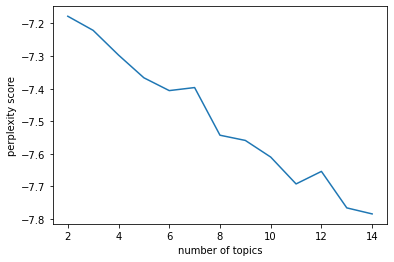

In [35]:
x = range(2,15)
plt.plot(x,perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

In [36]:
perplexity_values

[-7.177821682701315,
 -7.221124637366521,
 -7.296870563312785,
 -7.36660946110831,
 -7.405880974284963,
 -7.396557266077146,
 -7.542730139453914,
 -7.558726748538129,
 -7.609768852096498,
 -7.6921446532670466,
 -7.65368280631098,
 -7.765627581819251,
 -7.784124008237182]

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.14s/it]


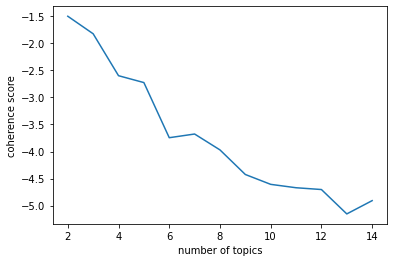

In [37]:
coherence_values=[]
for i in tqdm(range(2,15)):
    ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=i, iterations=400)
    #ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    #ldamodel = models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary, random_state=99)
    #coherence_model_lda=CoherenceModel(model=ldamodel, texts=corpus, dictionary=dictionary, topn=10)
    coherence_model_lda=CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    
x=range(2,15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()


In [38]:
coherence_values

[-1.4987958678918707,
 -1.8231244726581135,
 -2.598287088957785,
 -2.7253769456030055,
 -3.7448858099553752,
 -3.676697399043856,
 -3.9706537585710824,
 -4.425162595853604,
 -4.6074508513652095,
 -4.6701797108592755,
 -4.70319855981947,
 -5.154177453204701,
 -4.908557911557701]